In [77]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json
from tqdm.auto import tqdm
from src.metrics import AggregateMetric
import logging

from src.utils import logging_utils

# logging_utils.configure(level=logging.DEBUG)

## Loading the results

In [79]:
############################################
sweep_root = "../../results/sweep-24-trials"
# sweep_root = "../../results/sweep-bare"
model_name = "llama-13b"
############################################

sweep_path = f"{sweep_root}/{model_name}"

In [80]:
from src.utils.sweep_utils import read_sweep_results, relation_from_dict

In [81]:
sweep_results = read_sweep_results(sweep_path, economy=True)
list(sweep_results.keys())

['person occupation',
 'adjective antonym',
 'person mother',
 'country capital city',
 'plays pro sport',
 'star constellation name',
 'person plays instrument',
 'person university',
 'city in country',
 'food from country',
 'occupation gender',
 'occupation age',
 'name gender',
 'company hq',
 'word first letter',
 'country language',
 'object superclass',
 'name religion',
 'fruit outside color',
 'superhero archnemesis',
 'work location',
 'person lead singer of band',
 'landmark on continent',
 'characteristic gender',
 'country largest city',
 'country currency',
 'fruit inside color',
 'task done by tool',
 'verb past tense',
 'pokemon evolution',
 'product by company',
 'name birthplace',
 'word last letter',
 'word sentiment',
 'landmark in country',
 'company CEO',
 'superhero person',
 'person father',
 'substance phase of matter',
 'adjective superlative',
 'person sport position',
 'adjective comparative',
 'univ degree gender',
 'task person type',
 'person native lang

In [82]:
# sweep_results_bare = read_sweep_results("../../results/sweep-bare/gptj", economy=True)
# list(sweep_results_bare.keys())

In [83]:
# relation_name = "plays pro sport"
# relation_result = relation_from_dict(sweep_results[relation_name])
# relation_result_bare = relation_from_dict(sweep_results_bare[relation_name])

In [84]:
# efficacy = relation_result.best_by_efficacy()
# print(f"best by efficacy =>  layer={efficacy.layer}, beta={efficacy.beta.mean:.2f}, rank={efficacy.rank.mean:.0f}")
# print("recall:", efficacy.recall)
# print("efficacy:", efficacy.efficacy)

# print("-------------------------------------------------------------")

# faithfulness = relation_result.best_by_faithfulness()
# print(f"best by faithfulness => layer={faithfulness.layer}, beta={faithfulness.beta.mean:.2f}, rank={faithfulness.rank.mean:.0f}")
# print("recall:", faithfulness.recall)
# print("efficacy:", faithfulness.efficacy)

In [85]:
# beta = 2.25

# efficacy = relation_result.best_by_efficacy(beta = beta)
# print(f"best by efficacy =>  layer={efficacy.layer}, beta={efficacy.beta.mean:.2f}, rank={efficacy.rank.mean:.0f}")
# print("recall:", efficacy.recall)
# print("efficacy:", efficacy.efficacy)

# print("-------------------------------------------------------------")

# faithfulness = relation_result.best_by_faithfulness(beta = beta)
# print(f"best by faithfulness => layer={faithfulness.layer}, beta={faithfulness.beta.mean:.2f}, rank={faithfulness.rank.mean:.0f}")
# print("recall:", faithfulness.recall)
# print("efficacy:", faithfulness.efficacy)

In [86]:
##############################################################################
fig_dir = f"figs/{model_name}"
##############################################################################

In [87]:
plt.rcdefaults()
os.makedirs(fig_dir, exist_ok=True)
#####################################################################################
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=50)  # fontsize of the figure title
#####################################################################################

color_scheme = {
    "recall": "steelblue",
    "efficacy": "darkorange",
}

legend_labels = {
    "recall": "Faithfulness",
    "efficacy": "Causality",
}

def plot_layerwise(canvas, relation_result, attribute = "recall", best_criterion = "faithfulness", color = None, label = None):
    by_layer = relation_result.by_layer()

    layers = list(by_layer.keys())
    value_means = [value.__dict__[attribute].mean for value in by_layer.values()]
    value_stds = [value.__dict__[attribute].stdev for value in by_layer.values()]

    if(best_criterion == "faithfulness"):
        best_layer = relation_result.best_by_faithfulness()
    elif(best_criterion == "efficacy"):
        best_layer = relation_result.best_by_efficacy()
    
    color = color_scheme[attribute] if color is None else color
    label = legend_labels[attribute] if label is None else label
    
    # canvas.scatter([layers.index(best_layer.layer)], [best_layer.__dict__[attribute].mean], color="red", s=200)
    canvas.plot(range(len(layers)), value_means, color=color, linewidth=2, label = label)
    canvas.fill_between(range(len(layers)), np.array(value_means) - np.array(value_stds), np.array(value_means) + np.array(value_stds), color=color, alpha=0.07)

    if attribute in ["recall", "efficacy"]:
        canvas.set_ylim(0, 1)
    else:
        canvas.set_ylim(bottom=0)
    canvas.set_xlabel("Layer")
    canvas.set_ylabel(attribute)
    canvas.set_xticks(range(len(layers)), layers, rotation=90)
    test_samples = [trial.n_test_samples for trial in relation_result.trials]
    test_samples = np.array(test_samples)
    trial_info = f"[{test_samples.mean():.2f} ± {test_samples.std():.2f}]"
    canvas.set_title(f"{relation_result.relation_name} n_trials={len(test_samples)} {trial_info}\n{best_criterion} => h_layer: {best_layer.layer}, beta: {best_layer.beta.mean:.2f}, rank: {best_layer.rank.mean:.2f}, efficacy: {best_layer.efficacy.mean:.2f}")
    
    return canvas

In [88]:
def export_legend(legend, filename="legend.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

In [89]:
# nrows = 1
# ncols = 1
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))
# plot_layerwise(ax, relation_result, color = "steelblue", label="With relation-specific prompt")
# plot_layerwise(ax, relation_result_bare, color = "#00e6b8", label="W/o relation-specific prompt")
# # plot_layerwise(ax, relation_result, attribute="efficacy", best_criterion="efficacy")
# ax.set_ylabel("Faithfulness")
# ax.set_title("", fontsize=BIGGER_SIZE, pad=10)
# legend = plt.legend(ncol = 2, bbox_to_anchor=(0.5, 1.15), loc='upper center', frameon=False)

# export_legend(legend, f"{fig_dir}/legend-faith-causal.pdf")
# legend.remove()
# fig.tight_layout()
# plt.savefig(f"{fig_dir}/{model_name}-layer-mode-switch.pdf", bbox_inches="tight")
# # plt.savefig(f"{fig_dir}/{model_name}-sweep-bare.pdf", bbox_inches="tight")
# plt.show()

In [90]:
dataset = data.load_dataset()
all_relations = [
    relation.name for relation in dataset.relations
]
all_relations = sorted(all_relations)
# all_relations
failed_relations = list(set(all_relations) - set(sweep_results.keys()))
failed_relations = sorted(failed_relations)

failed_relations

['president birth year', 'president election year']

In [91]:
# ############################################
# efficacy_root = "../../results/efficacy_baselines-24-trials"
# ############################################""

# efficacy_path = f"{efficacy_root}/{model_name}"

In [92]:
from src.utils.sweep_utils import read_efficacy_baseline_results, format_efficacy_baseline_results

# efficacy_baseline_results = read_efficacy_baseline_results(efficacy_path)

# print(len(efficacy_baseline_results))
# list(efficacy_baseline_results.keys())

In [93]:
# relation_name = "work location"
# relation_result = relation_from_dict(sweep_results[relation_name])
# # format_efficacy_baseline_results(
# #     efficacy_baseline_results[relation_name]
# # )

In [94]:
# plt.rcdefaults()
# #####################################################################################
# plt.rcdefaults()
# plt.rcParams["figure.dpi"] = 200
# plt.rcParams["font.family"] = "Times New Roman"

# SMALL_SIZE = 14
# MEDIUM_SIZE = 18
# BIGGER_SIZE = 22

# plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
# plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
# plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
# plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
# plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
# plt.rc("figure", titlesize=50)  # fontsize of the figure title
# #####################################################################################

# nrows = 1
# ncols = 1
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))
# plot_layerwise(ax, relation_result, attribute="efficacy", best_criterion="efficacy")
# plot_efficacy_baseline(ax, efficacy_result)
# ax.set_ylabel("Success @ 1")
# ax.set_title(relation_name, fontsize=BIGGER_SIZE, pad=10)
# ax.legend(ncol = 1, bbox_to_anchor=(1, 1), loc='upper right')

# plt.savefig(f"{fig_dir}/{model_name}-causality_baselines.pdf", bbox_inches="tight")
# plt.show()

In [95]:
# ranks = {
#     layer : layer_summary.rank.values
#     for layer, layer_summary in relation_result.by_layer().items()
# }
# ranks

In [96]:
dataset = data.load_dataset()
interested_dataset = dataset.filter(
    # relation_type = ["factual"]
)

filtered_results = {}
for relation_name in tqdm(interested_dataset.relations):
    if relation_name.name not in sweep_results:
        continue
    relation_result = relation_from_dict(sweep_results[relation_name.name])
    if len(relation_result.trials) < (3 if model_name != "llama-13b" else 2):
        print(f"skipping {relation_name.name}, not enough trials, : {[trial.n_test_samples for trial in relation_result.trials]}")
        continue
    filtered_results[relation_name.name] = relation_result

  0%|          | 0/47 [00:00<?, ?it/s]

## Sweep Figures

In [97]:
# plt.rcdefaults()

# step_size = 3

# for _from in range(0, len(filtered_results), step_size):
#     _to = min(len(filtered_results), _from + step_size)
#     n_subplots = len(filtered_results) * 3
#     n_subplots = (_to - _from)  * 2
#     ncols=2
#     nrows=int(np.ceil(n_subplots/ncols))
#     fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6.5))
#     if n_subplots == 1:
#         axes = [axes]
#     if nrows == 1:
#         axes = [axes]

#     ax_col, ax_row = 0, 0
#     for i, (relation_name, relation_result) in list(enumerate(filtered_results.items()))[_from  : _to]:
#         print(i, relation_name)
#         result = filtered_results[relation_name]
#         plot_layerwise(axes[ax_row][0], result)
#         plot_layerwise(axes[ax_row][1], result, attribute="efficacy", best_criterion="efficacy")
#         # if(relation_name in efficacy_baseline_results):
#         #     efficacy_baselines = format_efficacy_baseline_results(efficacy_baseline_results[relation_name])
#         #     plot_efficacy_baseline(axes[ax_row][1], efficacy_baselines)
#         ax_row += 1

#     fig.tight_layout()
#     fig.show()

In [98]:
relation_result = filtered_results["country capital city"]
by_layer = relation_result.by_layer()
selected_layers = [list(by_layer.keys())[0]] + list(by_layer.keys())[1::3][1:]
selected_layers

['emb', 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39]

country capital city <class 'matplotlib.axes._axes.Axes'>
food from country <class 'matplotlib.axes._axes.Axes'>
word sentiment <class 'matplotlib.axes._axes.Axes'>
adjective comparative <class 'matplotlib.axes._axes.Axes'>
name birthplace <class 'matplotlib.axes._axes.Axes'>
name religion <class 'matplotlib.axes._axes.Axes'>
work location <class 'matplotlib.axes._axes.Axes'>
task done by tool <class 'matplotlib.axes._axes.Axes'>
company CEO <class 'matplotlib.axes._axes.Axes'>
pokemon evolution <class 'matplotlib.axes._axes.Axes'>
star constellation name <class 'matplotlib.axes._axes.Axes'>
person mother <class 'matplotlib.axes._axes.Axes'>


/tmp/ipykernel_3372/3525020148.py:73: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


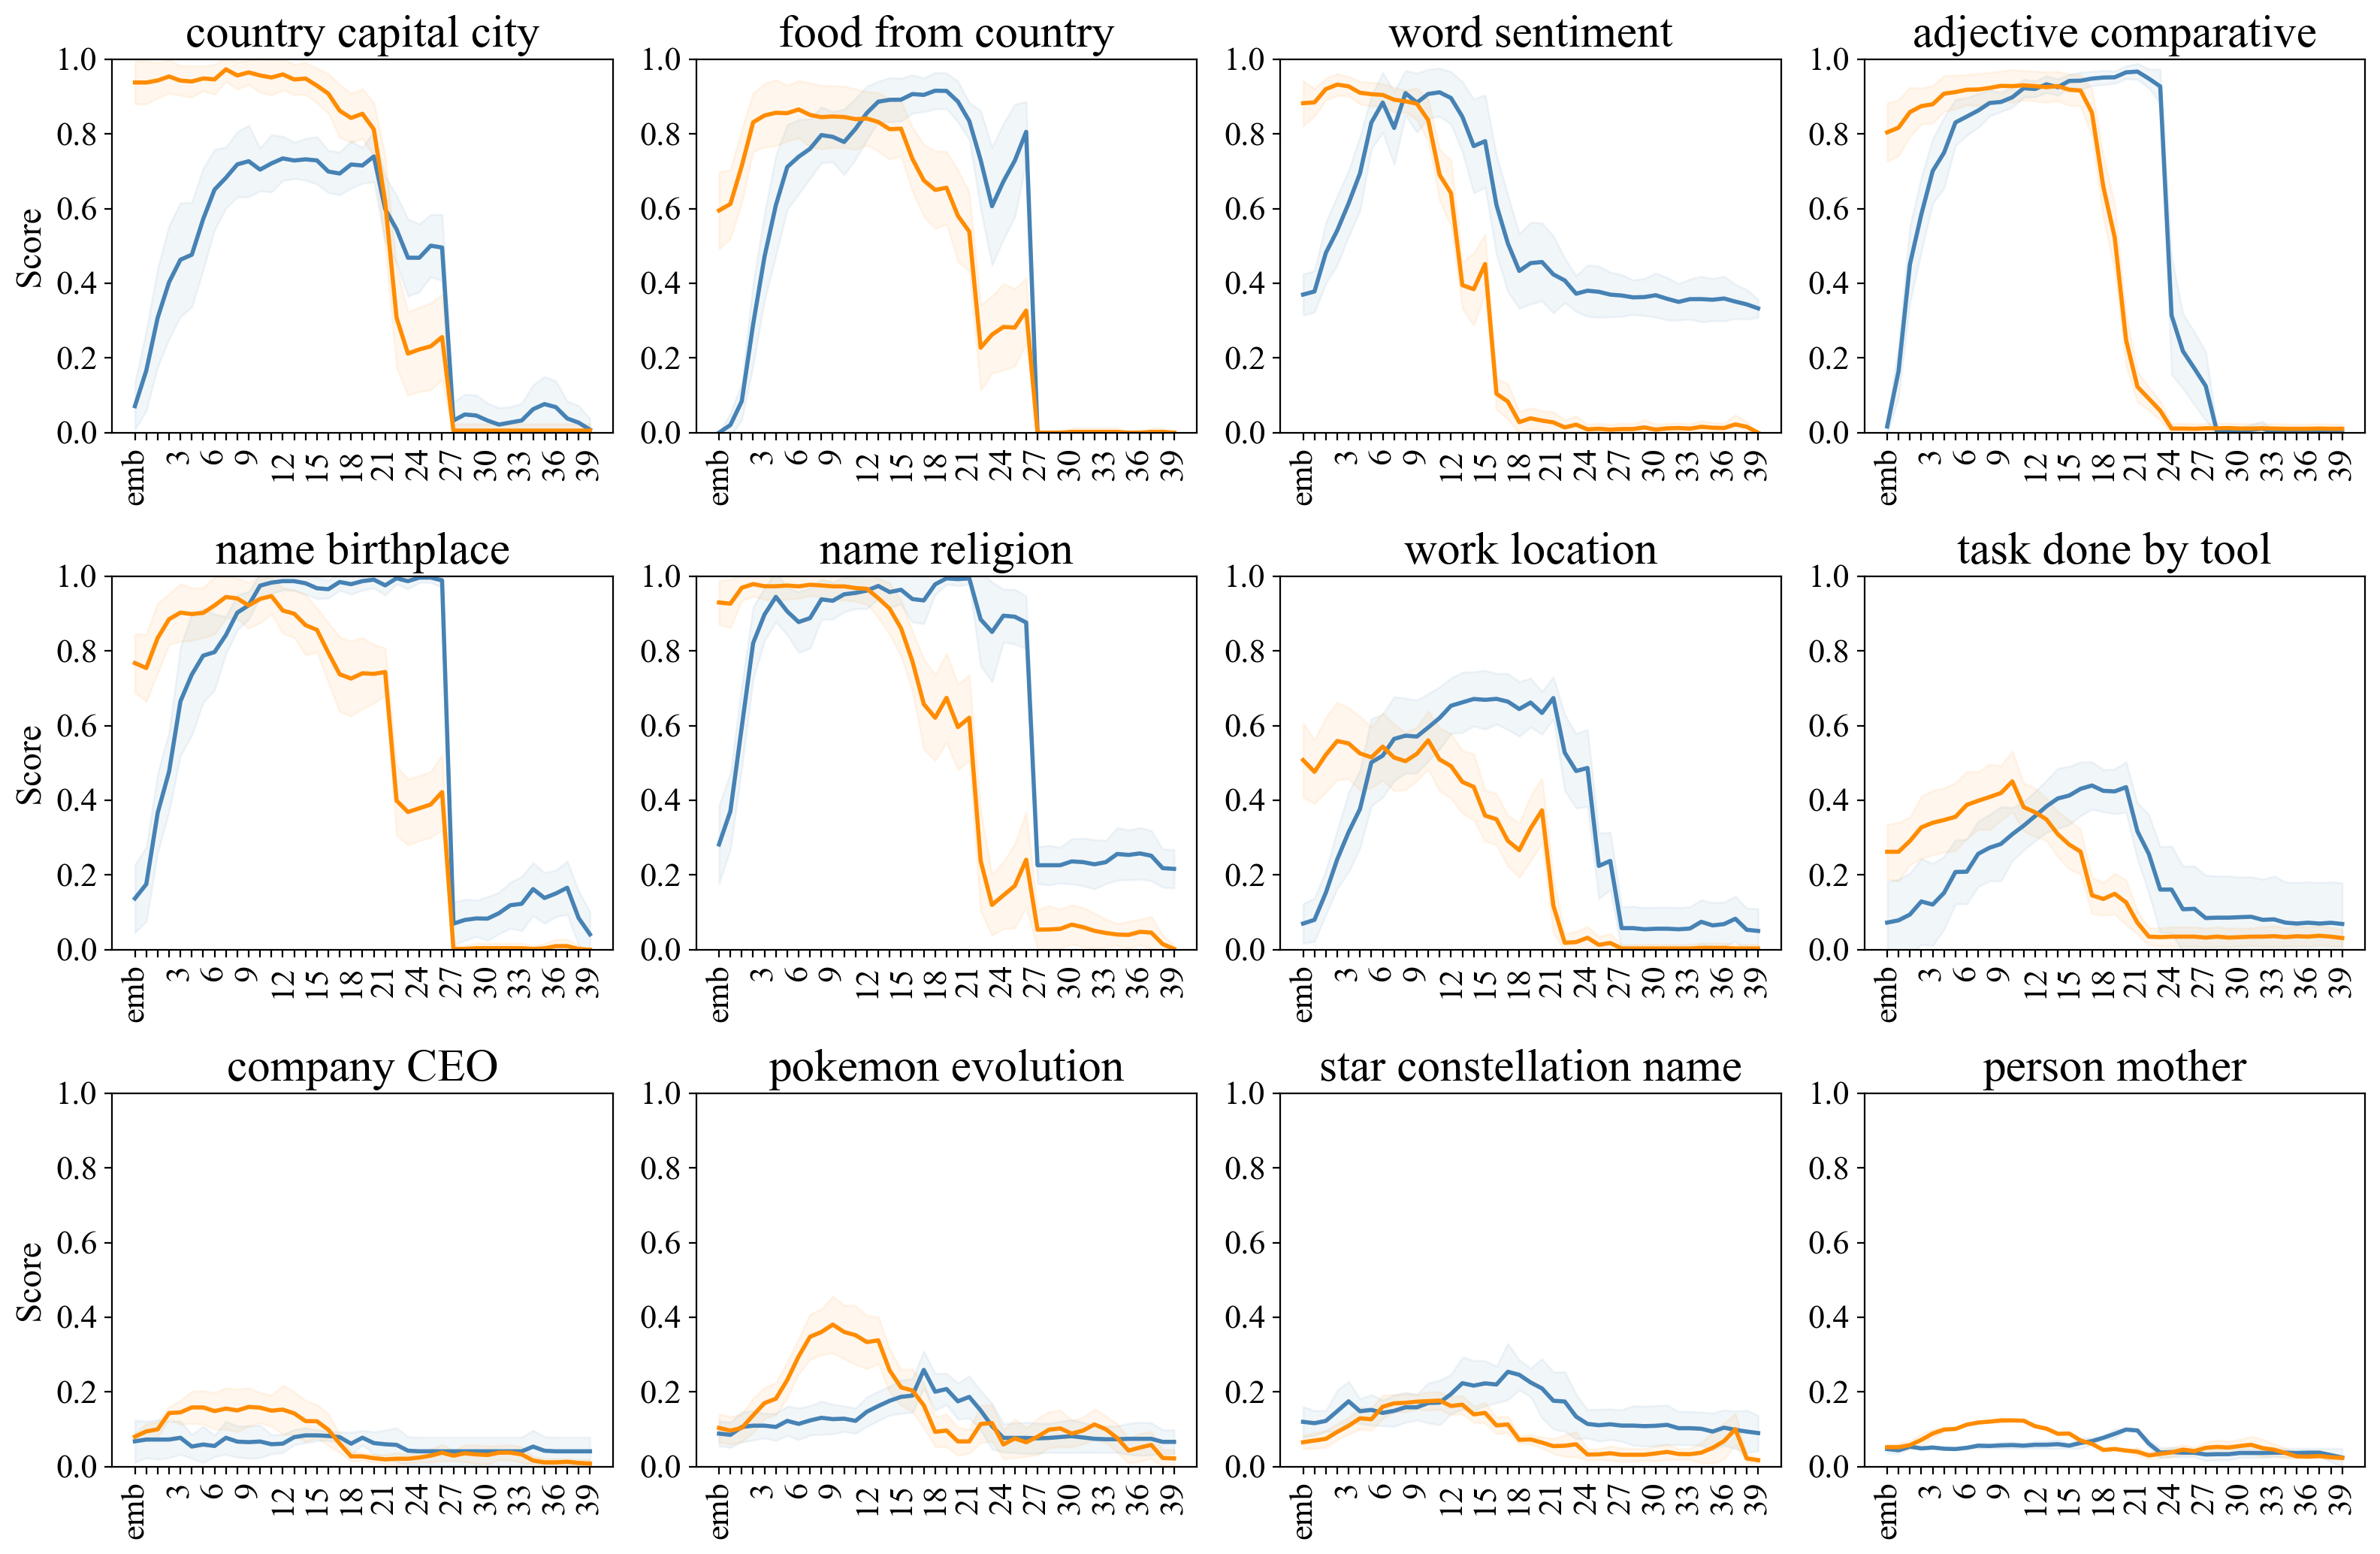

In [99]:
relation_names = [
    "country capital city", "food from country",
    "word sentiment", "adjective comparative",
    "name birthplace", "name religion",
    "work location", "task done by tool",
    "company CEO", "pokemon evolution", "star constellation name", "person mother"
]

#####################################################################################
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=50)  # fontsize of the figure title
#####################################################################################

n_cols = 4
n_rows = int(np.ceil(len(relation_names)/n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 3.5))

axes = [axes] if n_rows == 1 else axes
axes = [axes] if n_cols == 1 else axes

selected_layers = [list(by_layer.keys())[0]] + list(by_layer.keys())[1::3][1:]
layers = list(by_layer.keys())
layer_labels = []
for layer in layers:
    if layer in selected_layers:
        layer_labels.append(layer)
    else:
        layer_labels.append("")

cur_row = 0
cur_col = 0
for relation_name in relation_names:
    relation_result = filtered_results[relation_name]
    ax = axes[cur_row][cur_col]
    print(relation_name, type(ax))
    plot_layerwise(ax, relation_result)
    plot_layerwise(ax, relation_result, attribute="efficacy", best_criterion="efficacy")
    ax.set_title(relation_result.relation_name, fontsize=BIGGER_SIZE)
    ax.set_xticks(range(len(layers)), layer_labels)
    if cur_col == 0:
        ax.set_ylabel("Score")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

    if cur_col == 0 and cur_row == 0:
        legend = ax.legend(ncol=2, bbox_to_anchor=(0.5, 1.5), loc='upper center', frameon=False, fontsize=BIGGER_SIZE)
        export_legend(legend, f"{fig_dir}/legend-layerwise-sweep.pdf")
        legend.remove()

    cur_col += 1
    if cur_col == n_cols:
        cur_row += 1
        cur_col = 0


fig.tight_layout()
# plt.legend(ncol = 2, bbox_to_anchor=(0.5, 1.1), loc='upper center', frameon=False)
plt.savefig(f"{fig_dir}/{model_name}-sweeps.pdf", bbox_inches="tight")

fig.show()

## Causality vs Faithfulness Scatter Plots

In [100]:
def get_recall_vs_efficacy_info(sweep_results, criterion = "best", threshold = 30, beta = None):
    recalls = []
    efficacies = []
    pass_threshold = []
    labels = []
    for relation_name in sweep_results:
        if len(sweep_results[relation_name].trials) == 0:
            continue
        if criterion in ["best", "faithfulness"]:
            recalls.append(sweep_results[relation_name].best_by_faithfulness(beta = beta).recall.mean)
        else:
            recalls.append(sweep_results[relation_name].best_by_efficacy(beta = beta).recall.mean)
        if criterion in ["best", "efficacy"]:
            efficacies.append(sweep_results[relation_name].best_by_efficacy().efficacy.mean)
        else:
            efficacies.append(sweep_results[relation_name].best_by_faithfulness().efficacy.mean)
        
        test_samples = np.array([trial.n_test_samples for trial in sweep_results[relation_name].trials])
        pass_threshold.append(test_samples.min() >= threshold)
        labels.append(relation_name)

    return recalls, efficacies, pass_threshold, labels

/tmp/ipykernel_3372/938723771.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


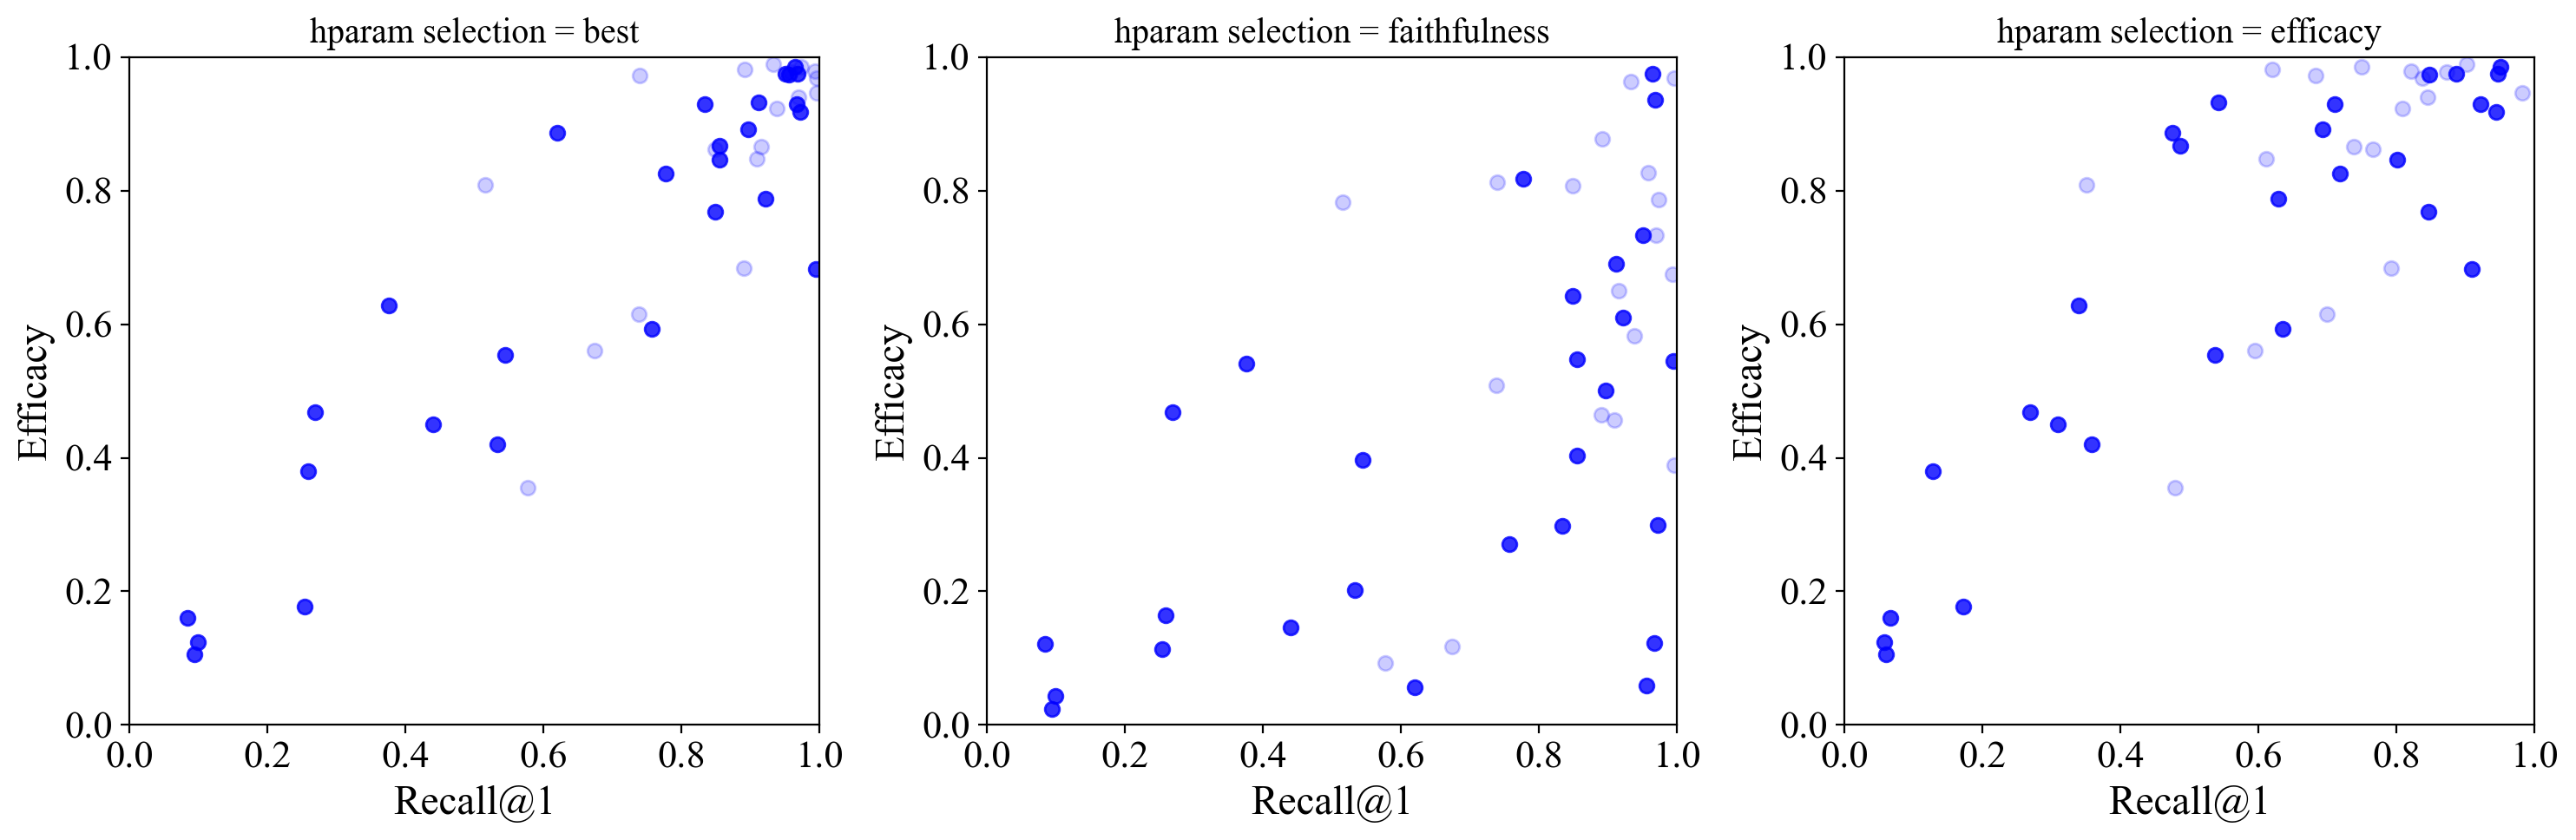

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for criterion, ax in zip(["best", "faithfulness", "efficacy"], axes):
    recalls, efficacies, pass_threshold, labels = get_recall_vs_efficacy_info(
        filtered_results, criterion=criterion, 
        # beta = 2.25
    )
    for recall, efficacy, threshold, relation_name in zip(recalls, efficacies, pass_threshold, labels):
        alpha = .8 if threshold else 0.2
        ax.scatter(recall, efficacy, color="blue", alpha=alpha)
        # if threshold and (recall/efficacy < .7 or efficacy/recall < .7):
        #     ax.annotate(relation_name, (recall, efficacy))


    ax.set_title(f"hparam selection = {criterion}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Recall@1")
    ax.set_ylabel("Efficacy")

fig.tight_layout()
fig.show()

In [102]:
recalls, efficacies, pass_threshold, labels = get_recall_vs_efficacy_info(
    filtered_results, criterion=criterion, 
    beta = 4
)
correlation = np.corrcoef(recalls, efficacies)[0, 1]
correlation

0.7198404882413773

In [103]:
from sklearn.linear_model import LinearRegression
import torch

def get_linear_model(recalls: list[float], efficacies: list[float]):
    X = torch.Tensor(recalls)[None].T
    y = torch.Tensor(efficacies)[None].T
    lm = LinearRegression().fit(X = X, y = y)
    slope = torch.Tensor(lm.coef_).squeeze().item()
    y_intercept = torch.Tensor(lm.intercept_).squeeze().item()
    r_squared = lm.score(X, y)
    return slope, y_intercept, r_squared



In [104]:
beta_options = [beta.beta for beta in relation_result.trials[0].layers[0].result.betas]
# beta_options

beta=0.0 | r_squared=0.08, slope=0.404, y_intercept=0.677
beta=0.5 | r_squared=0.13, slope=0.421, y_intercept=0.648
beta=1.0 | r_squared=0.16, slope=0.391, y_intercept=0.626
beta=1.5 | r_squared=0.19, slope=0.400, y_intercept=0.598
beta=2.0 | r_squared=0.25, slope=0.449, y_intercept=0.556
beta=2.5 | r_squared=0.33, slope=0.516, y_intercept=0.506
beta=3.0 | r_squared=0.40, slope=0.577, y_intercept=0.461
beta=3.5 | r_squared=0.46, slope=0.631, y_intercept=0.420
beta=4.0 | r_squared=0.52, slope=0.682, y_intercept=0.383
beta=4.5 | r_squared=0.56, slope=0.721, y_intercept=0.354
beta=5.0 | r_squared=0.60, slope=0.752, y_intercept=0.333
beta=5.5 | r_squared=0.63, slope=0.778, y_intercept=0.314
beta=6.0 | r_squared=0.65, slope=0.788, y_intercept=0.305
beta=6.5 | r_squared=0.66, slope=0.797, y_intercept=0.301
beta=7.0 | r_squared=0.67, slope=0.805, y_intercept=0.297
beta=7.5 | r_squared=0.68, slope=0.812, y_intercept=0.294
beta=8.0 | r_squared=0.68, slope=0.817, y_intercept=0.294
beta=8.5 | r_s

/tmp/ipykernel_3372/561082002.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


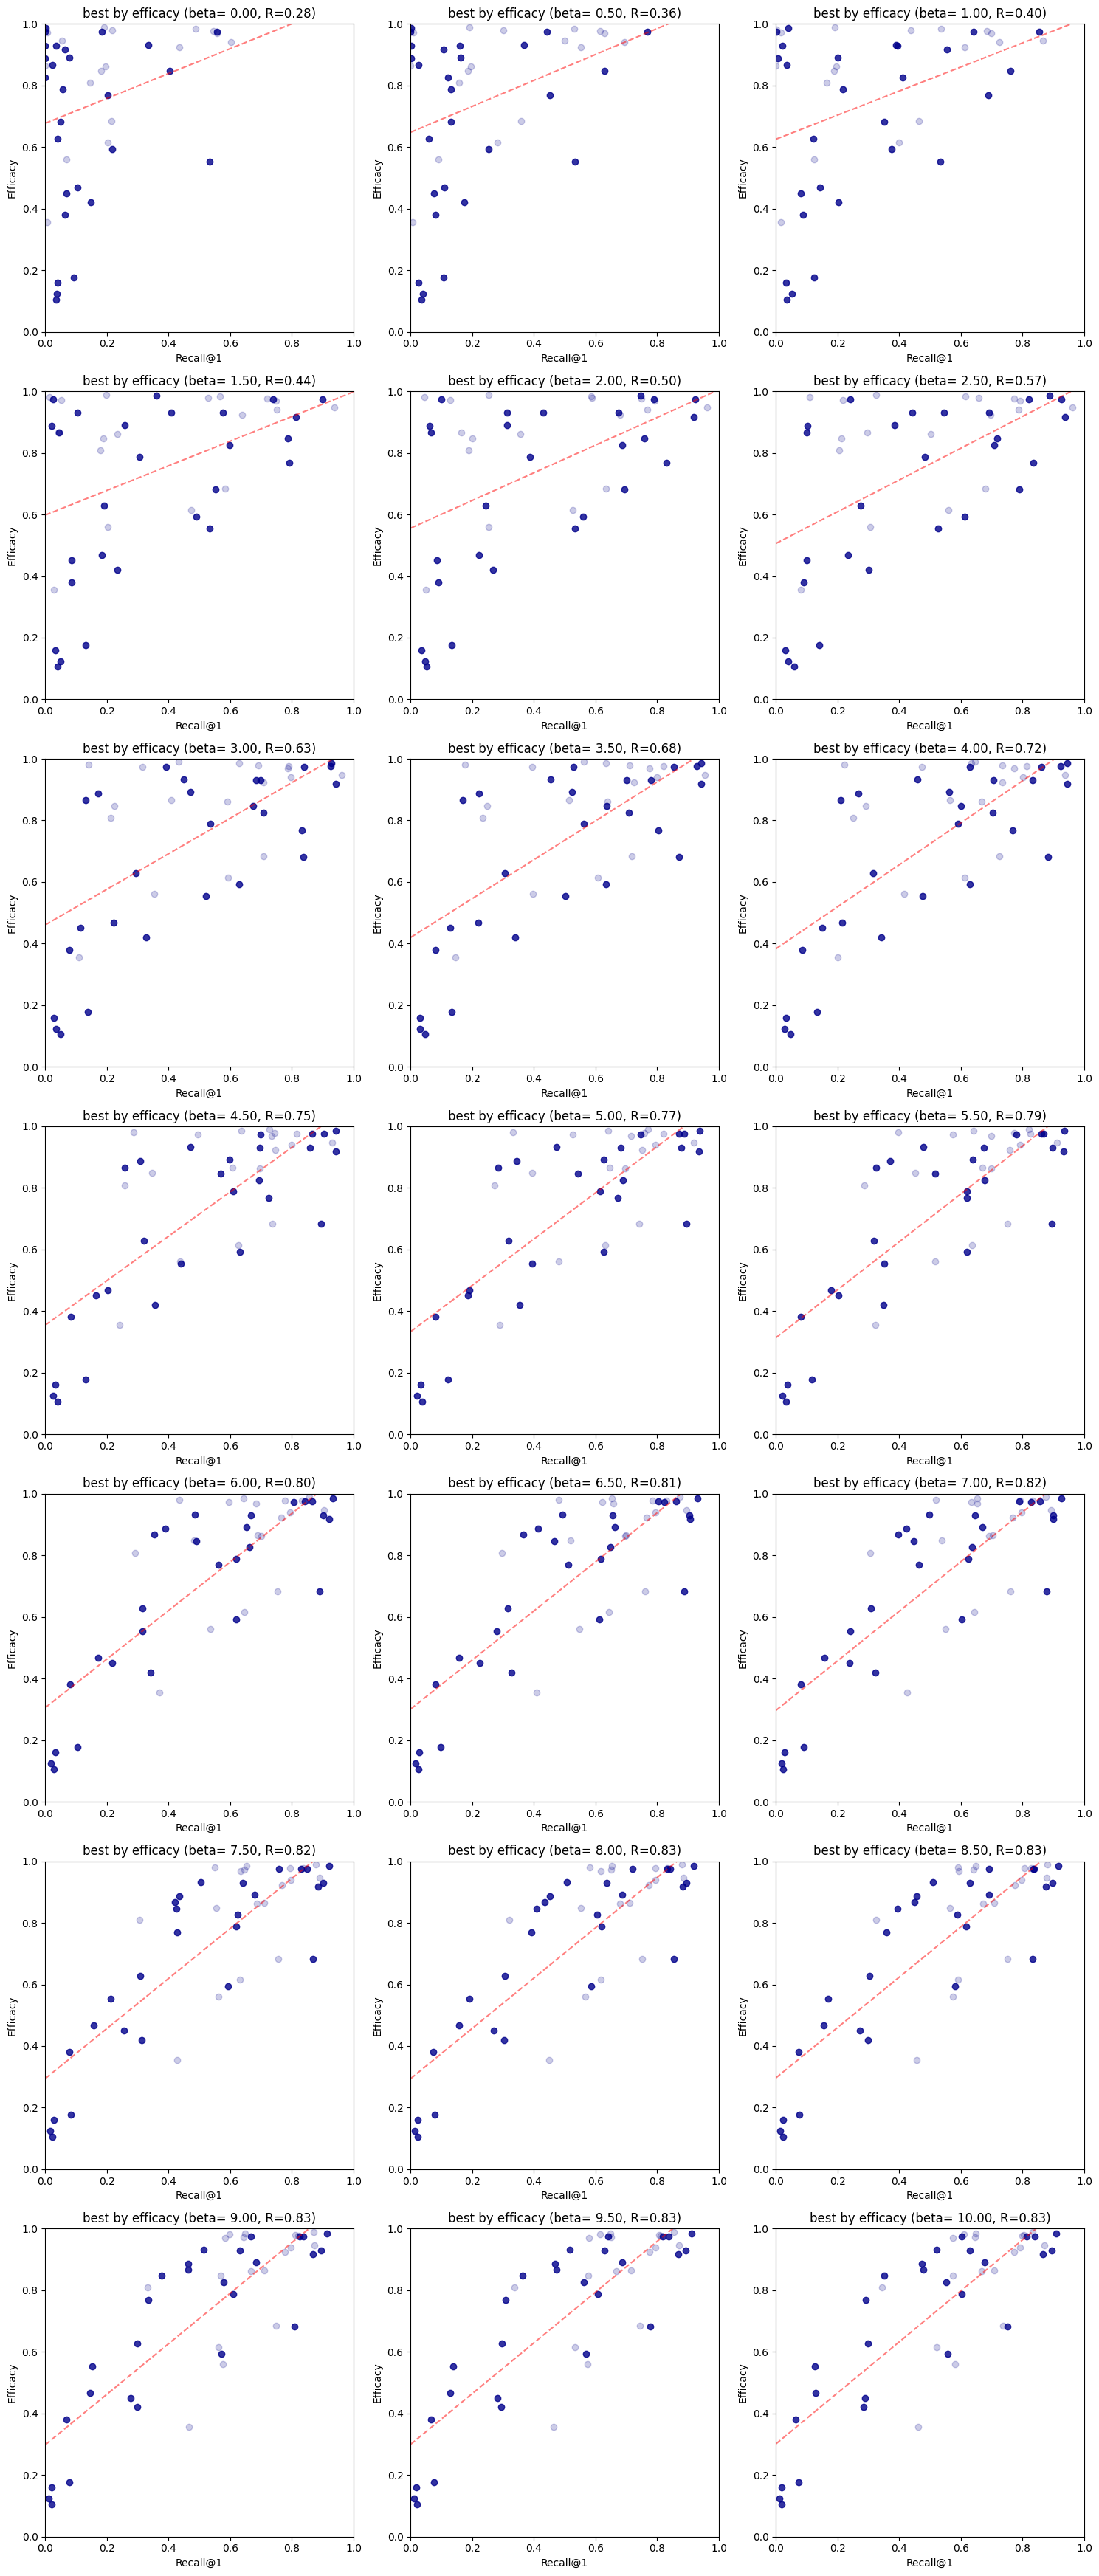

In [105]:
plt.rcdefaults()
num_figs = len(beta_options)
n_cols = 3
n_rows = int(np.ceil(num_figs/n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(5*n_cols, 5*n_rows))

scores_by_beta = []
cur_row, cur_col = 0, 0
for i, beta in enumerate(beta_options):
    recalls, efficacies, pass_threshold, labels = get_recall_vs_efficacy_info(filtered_results, criterion="efficacy", beta = beta)
    correlation = np.corrcoef(recalls, efficacies)[0, 1]

    scores_by_beta.append({
        "beta": f"{beta:.2f}",
        "recall_mean": f"{np.mean(recalls):.2f} ± {np.std(recalls):.2f}",
        "efficacy_mean": f"{np.mean(efficacies):.2f} ± {np.std(efficacies):.2f}",
        "R": f"{correlation:.2f}"
    })

    for recall, efficacy, threshold, relation_name in zip(recalls, efficacies, pass_threshold, labels):
        alpha = .8 if threshold else 0.2
        axes[cur_row][cur_col].scatter(recall, efficacy, color="darkblue", alpha=alpha)
        # if threshold and (recall/efficacy < .6 or efficacy/recall < .6):
        #     plt.annotate(relation_name, (recall, efficacy))

    slope, y_intercept, r_squared = get_linear_model(recalls, efficacies)

    print(f"{beta=} | {r_squared=:.2f}, {slope=:.3f}, {y_intercept=:.3f}")
    x = np.linspace(0, 1, 10)
    axes[cur_row][cur_col].plot(x, slope*x + y_intercept, color="red", linestyle="--", alpha=0.5)
    axes[cur_row][cur_col].set_title(
        f"best by efficacy (beta={beta : .2f}, R={correlation:.2f})", 
        # fontsize=BIGGER_SIZE
    )
    axes[cur_row][cur_col].set_xlim(0, 1)
    axes[cur_row][cur_col].set_ylim(0, 1)
    axes[cur_row][cur_col].set_xlabel("Recall@1")
    axes[cur_row][cur_col].set_ylabel("Efficacy")

    cur_col += 1
    if cur_col == n_cols:
        cur_row += 1
        cur_col = 0

fig.tight_layout()
fig.show()

Correlation: 0.83


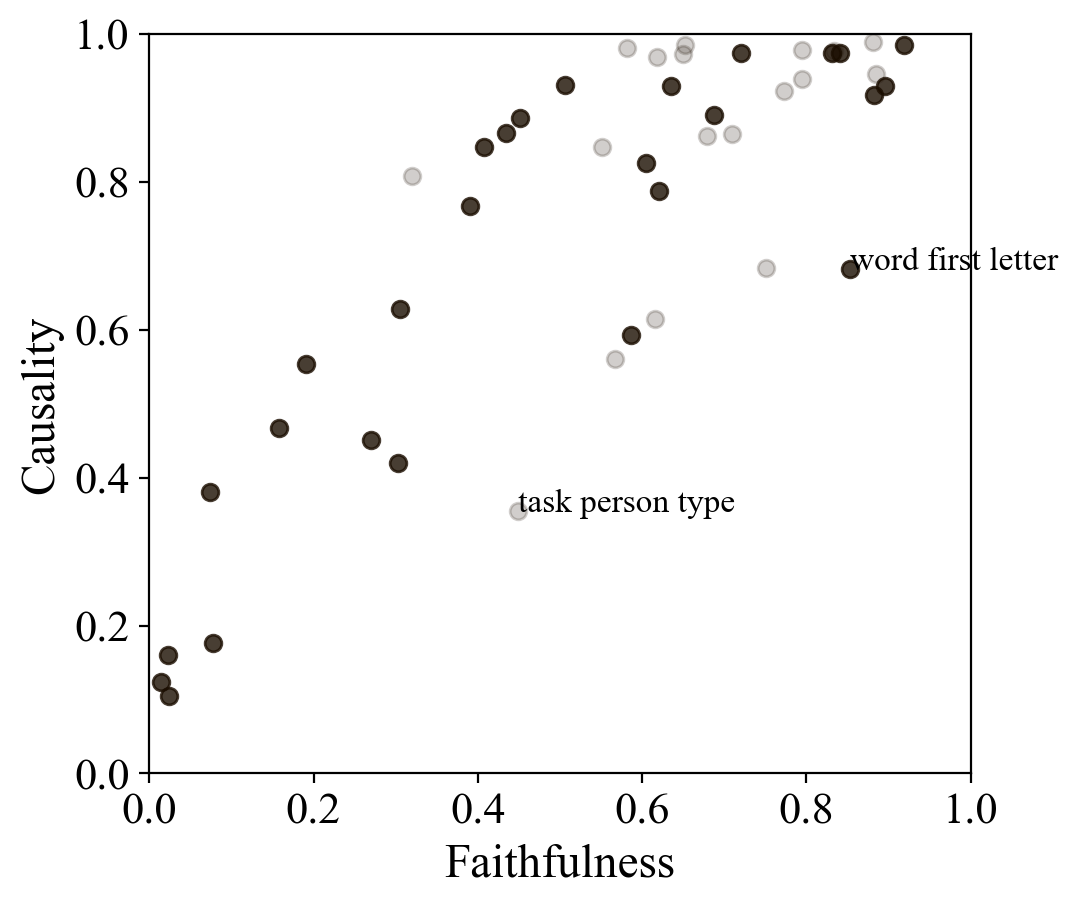

In [106]:
#####################################################################################
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=50)  # fontsize of the figure title
#####################################################################################

# plt.rcdefaults()


recalls, efficacies, pass_threshold, labels = get_recall_vs_efficacy_info(
    filtered_results, 
    criterion="efficacy", #"efficacy", # "faithfulness",
    beta=2.25 if "llama" not in model_name else 8.0
)
correlation = np.corrcoef(recalls, efficacies)[0, 1]
print(f"Correlation: {correlation :.2f}")

x = np.linspace(0, 1, 10)
slope, y_intercept, r_squared = get_linear_model(recalls, efficacies)
# plt.plot(x, slope*x + y_intercept, color="red", linestyle="--", alpha=0.5)

for recall, efficacy, threshold, relation_name in zip(recalls, efficacies, pass_threshold, labels):
    alpha = .8 if threshold else 0.2
    # plt.scatter(recall, efficacy, color="darkblue", alpha=alpha)
    plt.scatter(recall, efficacy, color="#1a0d00", alpha=alpha)
    dist = np.abs(slope * recall - efficacy + y_intercept)/(slope**2 + 1)**.5
    if dist > 0.2:
        plt.annotate(relation_name, (recall, efficacy))

# plt.title(
#     f"Faithfulness vs Causality", # (Correlation={correlation :.2f})", 
#     fontsize=BIGGER_SIZE
# )
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Faithfulness")
plt.ylabel("Causality")
plt.gca().set_aspect('.9')
plt.savefig(f"{fig_dir}/{model_name}-efficacy_vs_faithfulness.pdf", bbox_inches="tight")

plt.show()

In [107]:
import pandas as pd
df = pd.DataFrame(scores_by_beta)
# print(df[["beta", "recall_mean", "R"]].style.hide_index().to_latex())
os.makedirs("../../results/tables", exist_ok=True)
df.to_csv(f"../../results/tables/{model_name}-beta-R.csv", index=False)
df

,beta,recall_mean,efficacy_mean,R
0,0.00,0.17 ± 0.18,0.74 ± 0.26,0.28
1,0.50,0.23 ± 0.22,0.74 ± 0.26,0.36
2,1.00,0.30 ± 0.27,0.74 ± 0.26,0.40
3,1.50,0.37 ± 0.29,0.74 ± 0.26,0.44
4,2.00,0.42 ± 0.29,0.74 ± 0.26,0.50
5,2.50,0.46 ± 0.29,0.74 ± 0.26,0.57
6,3.00,0.49 ± 0.29,0.74 ± 0.26,0.63
7,3.50,0.51 ± 0.28,0.74 ± 0.26,0.68
8,4.00,0.53 ± 0.28,0.74 ± 0.26,0.72
9,4.50,0.54 ± 0.27,0.74 ± 0.26,0.75


## Faithfulness

In [108]:
model_name_dict = {
    "gpt2-xl": "GPT2-xl",
    "gptj": "GPT-J",
    "llama-13b": "LLaMa-13B",
}

In [109]:
import transformers

model_full_name = {
    "gptj": "EleutherAI/gpt-j-6B",
    "gpt2-xl": "gpt2-xl",
    "llama-13b": "/home/local_arnab/Codes/Weights/llama-13b"
}

if "llama" in model_name:
    tokenizer = transformers.LlamaTokenizerFast.from_pretrained(model_full_name[model_name])
    tokenizer.pad_token = tokenizer.eos_token = "</s>"
    tokenizer.pad_token_id = tokenizer.eos_token_id = 2
else:
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_full_name[model_name])
    tokenizer.pad_token = tokenizer.eos_token

company CEO: {'Sund': 3, 'El': 4, 'J': 3, 'Mark': 4, 'Y': 6, 'Daniel': 7, 'David': 6, 'A': 3, 'Tim': 4, 'Ch': 2, 'Kim': 1, 'Sat': 1, 'Ren': 1, 'Bob': 3, 'P': 3, 'Fer': 1, 'Andy': 2, 'Ar': 3, 'Ted': 1, 'D': 4, 'Chris': 1, 'Meg': 1, 'Sh': 2, 'Jonathan': 1, 'Joe': 1, 'James': 2, 'Ken': 2, 'Roy': 1, 'Michael': 1, 'Oliver': 3, 'Mary': 2, 'Dennis': 1, 'John': 3, 'Krist': 1, 'Jim': 4, 'Doug': 3, 'Andrew': 1, 'Lu': 1, 'Ed': 1, 'Marc': 2, 'Christian': 1, 'Patrick': 2, 'Stefan': 1, 'Man': 1, 'Christ': 2, 'Klaus': 1, 'Steven': 1, 'Terry': 1, 'O': 2, 'Bernard': 3, 'K': 2, 'H': 2, 'Alan': 3, 'Jon': 3, 'Simon': 1, 'Jam': 3, 'Car': 1, 'Alex': 2, 'Rég': 1, 'Ram': 1, 'Lawrence': 1, 'W': 2, 'Ark': 1, 'Kevin': 1, 'Dar': 1, 'Brian': 5, 'Werner': 1, 'Albert': 1, 'Frank': 1, 'Jen': 1, 'Charles': 2, 'Martin': 1, 'Lisa': 1, 'Mak': 1, 'Jeff': 1, 'X': 1, 'R': 2, 'Mar': 2, 'Á': 1, 'T': 2, 'Pet': 2, 'Stuart': 1, 'Barry': 1, 'Hans': 2, 'Z': 1, 'Warren': 1, 'Nicolas': 1, 'Jane': 1, 'Art': 1, 'Le': 1, 'Shin': 1, 'Ka

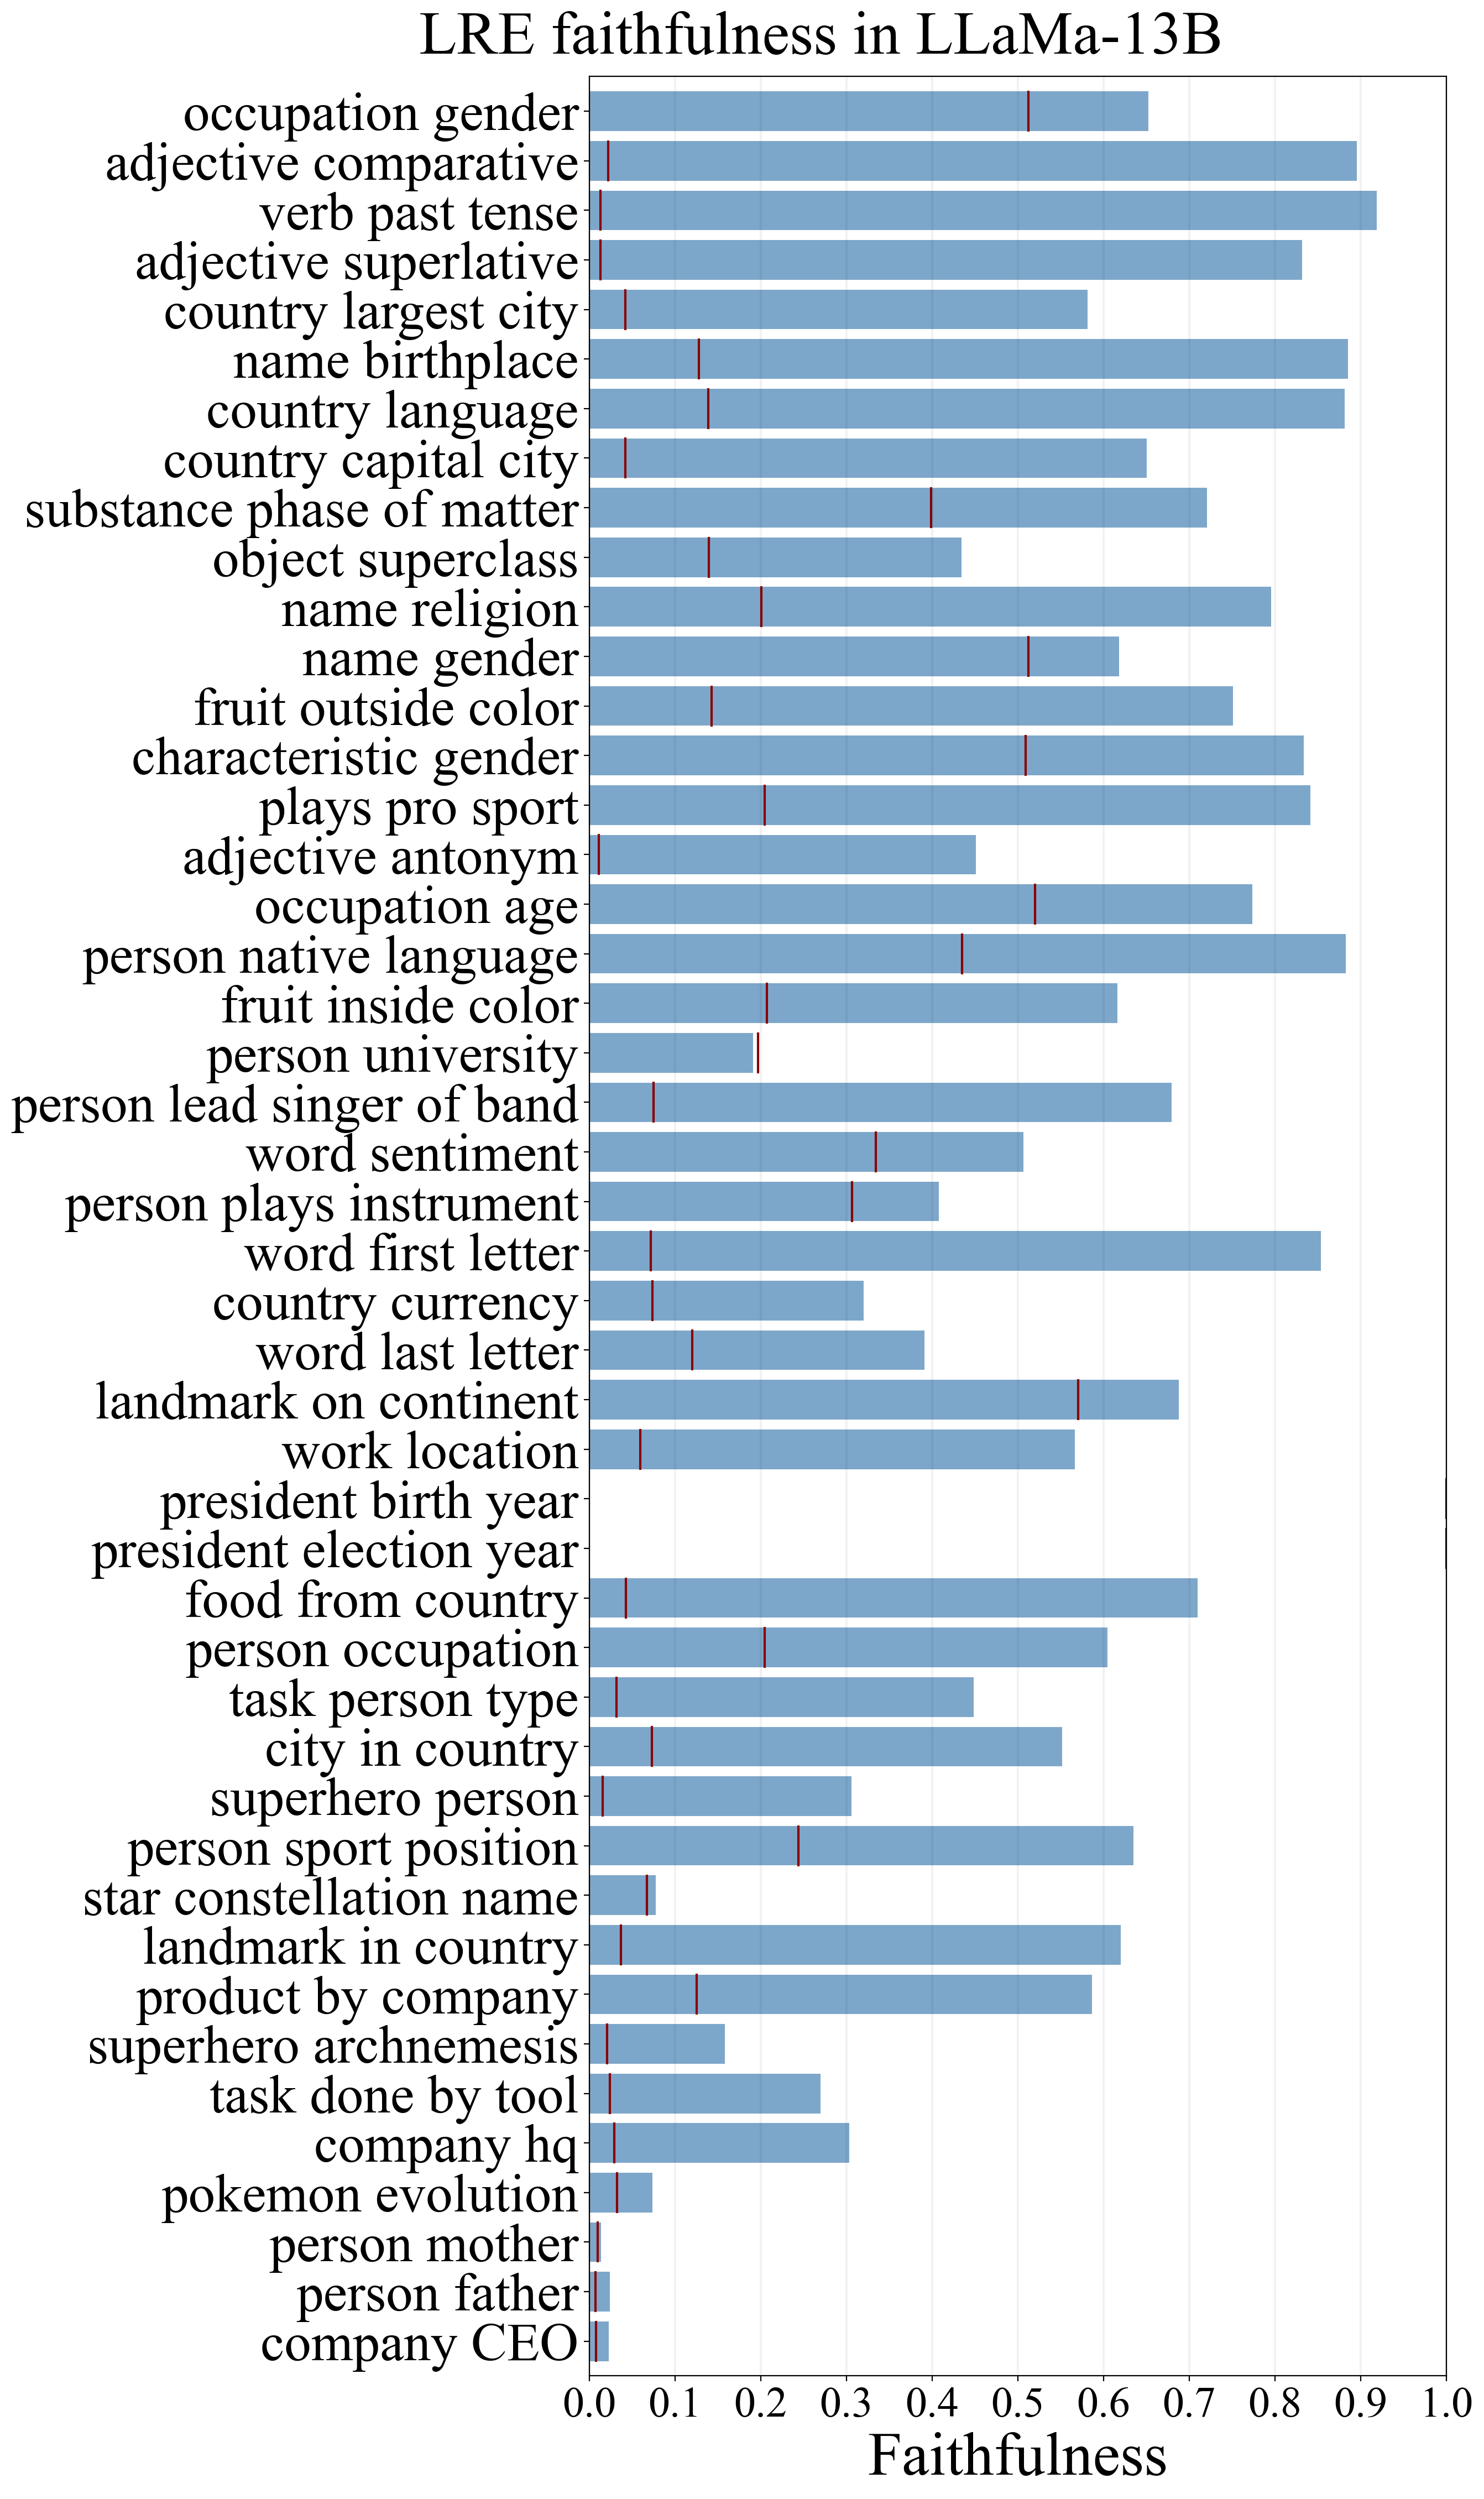

In [110]:
#####################################################################################
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 28
MEDIUM_SIZE = 35
BIGGER_SIZE = 40

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

relation_recall = []

for relation_name in filtered_results:
    relation_recall.append({
        "relation": relation_name,
        "recall@1": filtered_results[relation_name].best_by_efficacy(
            beta=2.25 if "llama" not in model_name else 8.0
        ).recall.mean
    })

if model_name == "gptj":
    relation_recall = sorted(relation_recall, key = lambda x: x["recall@1"])
    with open(f"relation_order_{model_name}.json", "w") as f:
        json.dump(relation_recall, f)
    plot_info = relation_recall
else:
    with open("relation_order_gptj.json", "r") as f:
        relation_order = json.load(f)
    relation_recall = {r["relation"]: r["recall@1"] for r in relation_recall}

    plot_info = []

    for r in relation_order:
        relation = r["relation"]
        recall = relation_recall[relation] if relation in relation_recall else 0
        plot_info.append({
            "relation": relation,
            "recall@1": recall
        })
    
    with open(f"relation_order_{model_name}.json", "w") as f:
        json.dump(plot_info, f)


relations = [r["relation"] for r in plot_info]
recalls = [r["recall@1"] for r in plot_info]

plt.figure(figsize = (10, 20))
plt.barh(np.arange(len(relations)), recalls, color = "steelblue", alpha = 0.7)
plt.yticks(np.arange(len(relations)), relations)
plt.xticks(np.linspace(0, 1, 11), [np.round(v, 1) for v in np.linspace(0, 1, 11)])
plt.ylim(-0.7,len(plot_info)-.3)
plt.xlabel("Faithfulness")
plt.xlim(0, 1)

with open(f"../../results/tables/known/{model_name}.json") as f:
    model_known = json.load(f)

for idx in range(len(plot_info)):
    relation_name = plot_info[idx]["relation"]
    d_relation = dataset.filter(relation_names=[relation_name])[0]
    ans_counter = {}
    for sample in d_relation.samples:
    # for sample in model_known[relation_name]["known_samples"]:
        obj = sample.object
        # obj = sample["object"]
        first_token = tokenizer(obj, return_tensors="pt").input_ids[0][1 if "llama" in model_name else 0]
        obj = tokenizer.decode(first_token)
        if obj not in ans_counter:
            ans_counter[obj] = 0
        ans_counter[obj] += 1
    print(relation_name, end=": ")
    # majority_ans, majority_ans_count = max(ans_counter.items(), key = lambda x: x[1]) if len(ans_counter) > 0 else (0, 0)

    # # divide_by = len(model_known[relation_name]["known_samples"]) if len(ans_counter) > 0 else 1
    # divide_by = len(d_relation.samples)
    # print(f" -- {majority_ans} --- {majority_ans_count} / {divide_by}")
    # random_baseline = majority_ans_count/divide_by

    divide_by = len(d_relation.samples)
    random_baseline = 0
    for o, o_count in ans_counter.items():
        random_baseline += o_count**2
    random_baseline /= divide_by**2

    print(ans_counter)
    plt.scatter(random_baseline, idx, color = "darkred", alpha = 1, marker="|", s = 700)

for x_tick in np.linspace(0, 1, 11):
    plt.axvline(x_tick, color = "black", alpha = 0.05)

plt.title(f"LRE faithfulness in {model_name_dict[model_name]}", x = 0.27, pad=15, fontsize=BIGGER_SIZE)

fig = plt.gcf()
fig.set_size_inches(10, 27)

plt.savefig(f"{fig_dir}/{model_name}-faithfulness_lre_relationwise.pdf", bbox_inches="tight")

plt.show()

## Generate Table

In [111]:
table = []
dataset = data.load_dataset()

for relation_name, sweep_result in filtered_results.items():
    efficacy_hparams = sweep_result.best_by_efficacy(beta=2.25 if "llama" not in model_name else 8.0)
    relation = dataset.filter(
        relation_names=[relation_name]
    )[0]
    table.append({
        "relation": relation_name,
        "n_range": len(relation.range),
        "layer": efficacy_hparams.layer,
        "beta": f"{efficacy_hparams.beta.mean: .2f} ± {efficacy_hparams.beta.stdev: .2f}",
        "rank": f"{int(efficacy_hparams.rank.mean)} ± {int(efficacy_hparams.rank.stdev)}",
        "recall@1": f"{efficacy_hparams.recall.mean: .2f} ± {efficacy_hparams.recall.stdev: .2f}",
        "efficacy": f"{efficacy_hparams.efficacy.mean: .2f} ± {efficacy_hparams.efficacy.stdev: .2f}",
        # "n_range": f"{len(relation.range)}",
    })

In [112]:
# sorted_table = sorted(table, key=lambda x: x["efficacy"], reverse=True)
sorted_table = sorted(table, key=lambda x: x["relation"])

In [113]:
df = pd.DataFrame(sorted_table)
os.makedirs("../../results/tables", exist_ok=True)
df.to_csv(f"../../results/tables/{model_name}-hparams.csv", index=False)
# print(df.to_markdown(index = False, tablefmt="github"))
# print(df.to_latex(index=False, escape=False))
df

,relation,n_range,layer,beta,rank,recall@1,efficacy
0,adjective antonym,95,7,8.00 ± 0.00,286 ± 84,0.45 ± 0.07,0.89 ± 0.03
1,adjective comparative,57,11,8.00 ± 0.00,208 ± 101,0.90 ± 0.03,0.93 ± 0.04
2,adjective superlative,79,7,8.00 ± 0.00,234 ± 111,0.83 ± 0.03,0.97 ± 0.02
3,characteristic gender,2,3,8.00 ± 0.00,43 ± 27,0.83 ± 0.10,0.98 ± 0.03
4,city in country,21,4,8.00 ± 0.00,81 ± 25,0.55 ± 0.18,0.85 ± 0.09
5,company CEO,287,9,8.00 ± 0.00,112 ± 24,0.02 ± 0.01,0.16 ± 0.05
6,company hq,163,11,8.00 ± 0.00,170 ± 95,0.30 ± 0.03,0.42 ± 0.06
7,country capital city,24,7,8.00 ± 0.00,107 ± 45,0.65 ± 0.10,0.97 ± 0.03
8,country currency,23,2,8.00 ± 0.00,56 ± 16,0.32 ± 0.11,0.81 ± 0.08
9,country language,14,10,8.00 ± 0.00,97 ± 59,0.88 ± 0.09,0.99 ± 0.02


### Single vs Multi token subjects

In [114]:
# def read_and_parse_sweep_results(sweep_path):
#     sweep_results = read_sweep_results(sweep_path)
#     for relation in sweep_results:
#         sweep_results[relation] = parse_results(sweep_results[relation])
#     return sweep_results

In [115]:
# sweep_single_path = f"../../results/sweep-single/{model_name}"
# sweep_single = read_and_parse_sweep_results(sweep_single_path)

# sweep_multi_path = f"../../results/sweep-multi/{model_name}"
# sweep_multi = read_and_parse_sweep_results(sweep_multi_path)

In [116]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4.5))

# for criterion, ax in zip(["best", "faithfulness", "efficacy"], axes):
#     single_recalls, single_efficacies, pass_single, single_labels = get_recall_vs_efficacy_info(sweep_single, criterion=criterion)
#     multi_recalls, multi_efficacies, pass_multi, multi_labels = get_recall_vs_efficacy_info(sweep_multi, criterion=criterion)
#     labeled = False
#     for r, e, p, l in zip(single_recalls, single_efficacies, pass_single, single_labels):
#         alpha = .8 if p else 0.2
#         if (alpha == 0.8 and not labeled):
#             ax.scatter(r, e, color = "blue", label = "single", alpha = alpha)
#             labeled = True
#         else:
#             ax.scatter(r, e, color = "blue", alpha = alpha)
#         if p and (r/e < .7 or e/r < .7):
#             ax.annotate(l, (r, e))

#     labeled = False
#     for r, e, p, l in zip(multi_recalls, multi_efficacies, pass_multi, multi_labels):
#         alpha = .8 if p else 0.2
#         alpha = .8 if p else 0.2
#         if (alpha == 0.8 and not labeled):
#             ax.scatter(r, e, color = "red", label = "multi", marker = "s", alpha = alpha)
#             labeled = True
#         else:
#             ax.scatter(r, e, color = "red", marker = "s", alpha = alpha)
#         if p and (r/e < .7 or e/r < .7):
#             ax.annotate(l, (r, e))

#     ax.set_title(f"Efficacy vs Recall ({criterion})")
#     ax.set_xlim(0, 1)
#     ax.set_ylim(0, 1)
#     ax.set_xlabel("Recall")
#     ax.set_ylabel("Efficacy")
#     ax.legend()